Concatenation, intermediate fusion. no extra pre-processing


CNN features  ─┐

               ├─ Concatenate → Dense → Output

ViT features ─┘



In [ ]:
pip install tensorflow

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataSet


dataset_path = '/content/drive/MyDrive/dataset/AMDNet23_Dataset'
IMG_SIZE = 224  # Image size for input (224x224 for most models)


# Get class names from the 'train' split folder
train_split_path = os.path.join(dataset_path, 'train')

if not os.path.exists(train_split_path):
    raise FileNotFoundError(f"Training split folder not found at '{train_split_path}'. ")


class_names = sorted([d for d in os.listdir(train_split_path) if os.path.isdir(os.path.join(train_split_path, d))])
if not class_names:
    raise ValueError(f"No class folders found inside '{train_split_path}'. "
                     f"Expected structure: {train_split_path}/class_name/images. ")

print(f"Detected Class names: {class_names}")


Detected Class names: ['amd', 'cataract', 'diabetes', 'normal']


In [ ]:
#Data Distribution

image_counts = {class_name: 0 for class_name in class_names}
for split_name in ['train', 'valid']:
    split_folder = os.path.join(dataset_path, split_name)
    if os.path.isdir(split_folder):
        print(f"--- Processing split: {split_name} ---")
        for class_name in class_names:
            class_folder = os.path.join(split_folder, class_name)
            if os.path.isdir(class_folder):
                current_count = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])
                image_counts[class_name] += current_count
                print(f"  Class '{class_name}': {current_count} images in {split_name}")
            else:
                print(f"  Warning: Class folder '{class_folder}' not found in split '{split_name}'.")
    else:
        print(f"Warning: Split folder '{split_folder}' not found. Skipping.")
print("Total Image distribution across all classes:", image_counts)



--- Processing split: train ---
  Class 'amd': 394 images in train
  Class 'cataract': 400 images in train
  Class 'diabetes': 400 images in train
  Class 'normal': 400 images in train
--- Processing split: valid ---
  Class 'amd': 100 images in valid
  Class 'cataract': 100 images in valid
  Class 'diabetes': 100 images in valid
  Class 'normal': 100 images in valid
Total Image distribution across all classes: {'amd': 494, 'cataract': 500, 'diabetes': 500, 'normal': 500}


In [ ]:
# Data Preprocessing --> (CLAHE + Gamma Correction + Resize)

def preprocess_image(image_path):
    image = cv2.imread(image_path)  # Read image
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB from BGR, cause most deep learning frameworks expect RGB order.

    # Apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Apply Gamma Correction
    gamma = 1.5
    image = np.array(image / 255.0, dtype=np.float32)
    image = np.power(image, gamma)

    # Resize the image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    return image

In [ ]:
#load images

def load_images_from_split(base_dataset_path, split_name, class_names_list):
    images = []
    labels = []

    split_folder = os.path.join(base_dataset_path, split_name)
    if not os.path.isdir(split_folder):
        raise ValueError(f"Split folder not found: {split_folder}")

    for class_name in class_names_list:
        class_folder = os.path.join(split_folder, class_name)
        if not os.path.isdir(class_folder):
            print(f"Skipping missing class folder: {class_folder}")
            continue

        for filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, filename)

            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Could not read image {image_path}")
                    continue

                # BGR → RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Normalize (NOT enhancement)
                image = image.astype(np.float32) / 255.0

                images.append(image)
                labels.append(class_name)

    return np.array(images), np.array(labels)


X_train_all, y_train_all = load_images_from_split(
    dataset_path,
    'train',
    class_names
)

X_test, y_test = load_images_from_split(
    dataset_path,
    'valid',
    class_names
)



In [ ]:
# # Ensure there are images loaded before proceeding
# if len(images) == 0:
#     raise ValueError("No images were loaded. Please check dataset_path and its structure.")

# # Encode labels
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)


In [ ]:
# Data Augmentation setup

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# dataset split

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=42)


print(f"Training images: {len(X_train)}, Validation images: {len(X_val)}, Test images: {len(X_test)}")

Training images: 1115, Validation images: 479, Test images: 400


In [ ]:
# Model

def cnn_feature_extractor(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    base_model = EfficientNetB0(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    return models.Model(inputs, x, name="cnn_feature_extractor")



def vit_feature_extractor(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    try:
        vit_base = tf.keras.applications.VisionTransformer(
            input_shape=input_shape,
            include_top=False,
            weights="imagenet"
        )
    except AttributeError:
        print("Warning: VisionTransformer not found. Using MobileNetV2 as ViT-like encoder.")
        vit_base = tf.keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights="imagenet"
        )

    vit_base.trainable = False  # start frozen

    inputs = layers.Input(shape=input_shape)
    x = vit_base(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    return models.Model(inputs, x, name="vit_feature_extractor")

cnn_encoder = cnn_feature_extractor()
vit_encoder = vit_feature_extractor()

def build_intermediate_fusion_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    inputs = layers.Input(shape=input_shape)

    cnn_features = cnn_encoder(inputs)
    vit_features = vit_encoder(inputs)

    fused_features = layers.Concatenate()([cnn_features, vit_features])

    x = layers.Dense(512, activation='relu', name="fusion_dense")(fused_features)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(
        len(class_names),
        activation='softmax',
        name="output_layer"
    )(x)

    model = models.Model(
        inputs=inputs,
        outputs=outputs,
        name="cnn_vit_intermediate_fusion_model"
    )

    return model

hybrid_model = build_intermediate_fusion_model()

hybrid_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "cnn_vit_intermediate_fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_feature_extrac… │ (None, 512)       │  4,705,443 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_feature_extrac… │ (None, 512)       │  2,913,856 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ cnn_feature_extr… │
│ (Concatenate)       │                   │            │ vit_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 512)       │    524,800 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ fusion_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 4)         │      2,052 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,146,151 (31.08 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 6,307,555 (24.06 MB)

Mapping labels: {'amd': 0, 'cataract': 1, 'diabetes': 2, 'normal': 3}
X_train shape: (1115, 224, 224, 3), y_train shape: (1115,)
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5386 - loss: 1.1408 - val_accuracy: 0.8058 - val_loss: 0.5003
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7125 - loss: 0.6813 - val_accuracy: 0.8184 - val_loss: 0.4316
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7955 - loss: 0.5295 - val_accuracy: 0.8246 - val_loss: 0.4009
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8159 - loss: 0.4743 - val_accuracy: 0.8225 - val_loss: 0.4315
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8269 - loss: 0.4151 - val_accuracy: 0.8476 - val_loss: 0.3646
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8685 - loss: 0.3567 - val_accuracy: 0.8351 - val_loss: 0.3855
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8642 - loss: 0.3330 - val_accuracy: 0.8455 -

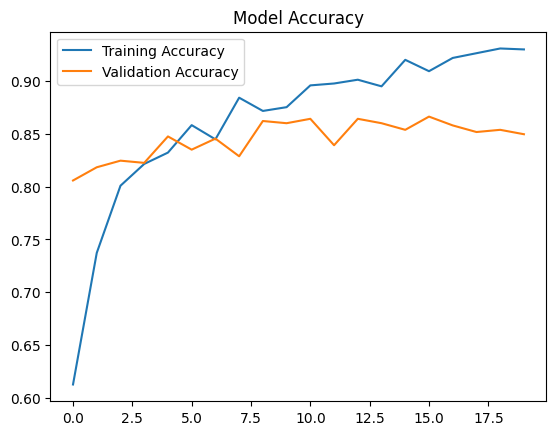

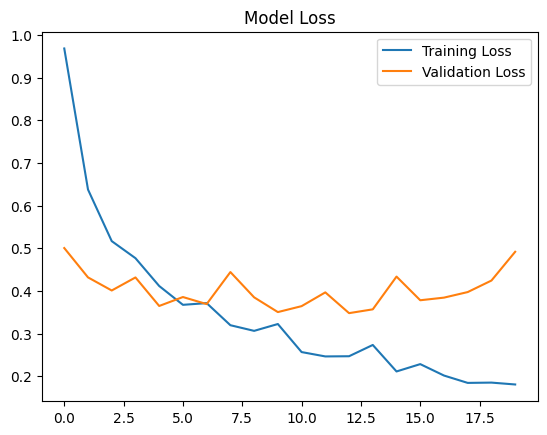

In [ ]:
#Training Set Up

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)



batch_size = 32

label_map = {name: i for i, name in enumerate(class_names)}
print(f"Mapping labels: {label_map}")

y_train = np.array([label_map[label] for label in y_train]).astype('int32')
y_val = np.array([label_map[label] for label in y_val]).astype('int32')
y_test = np.array([label_map[label] for label in y_test]).astype('int32')

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = hybrid_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


# accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
--- Classification Report ---
              precision    recall  f1-score   support

         amd       0.86      0.92      0.89       100
    cataract       0.99      0.98      0.98       100
    diabetes       0.92      0.69      0.79       100
      normal       0.82      0.98      0.89       100

    accuracy                           0.89       400
   macro avg       0.90      0.89      0.89       400
weighted avg       0.90      0.89      0.89       400



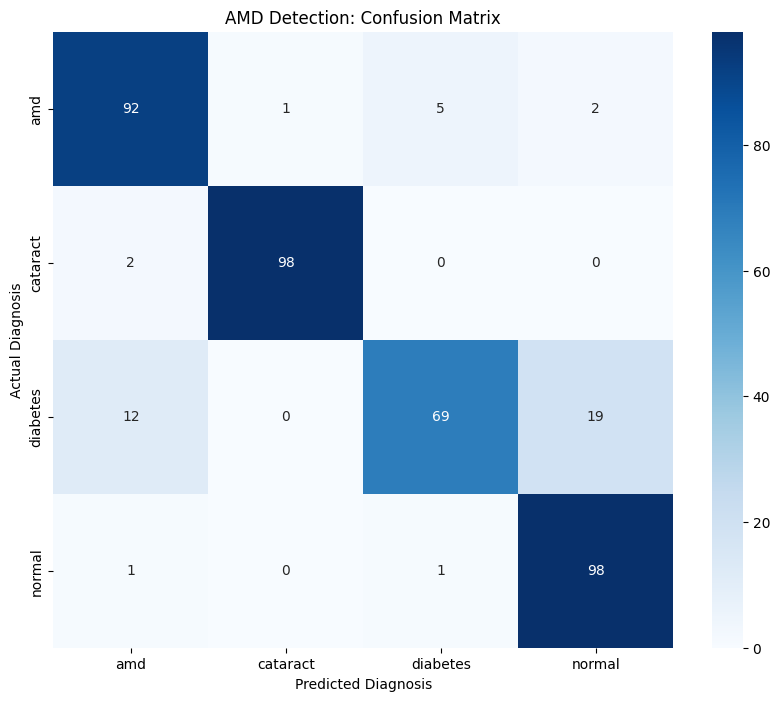

In [ ]:
#Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred = hybrid_model.predict(X_test, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)


print("--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('AMD Detection: Confusion Matrix')
plt.ylabel('Actual Diagnosis')
plt.xlabel('Predicted Diagnosis')
plt.show()